### Cab-Driver Agent

In [1]:
from collections import deque
import collections
import pickle
import matplotlib.pyplot as plt

import numpy as np
import random
import math


# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam



In [2]:
from Env import CabDriver
env = CabDriver()

#### Defining Time Matrix

In [3]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [4]:
def encode_tracking_state(state):
    track_state = []
    for e in state:
        track_state.append(str(e))
    return '-'.join(track_state)

In [5]:
def encode_tracking_action(action):
    track_action = []
    for e in action:
        track_action.append(str(e))
    return '-'.join(track_action)

In [6]:
def initialise_tracking_states(episodes):
    sample_q_values = [('3-0-0', '3-4'), ('2-0-0', '2-3'), ('1-0-0', '2-3'), ('4-0-0', '3-1'), ('4-0-0', '1-4'), ('4-0-0', '4-1'), 
                       ('4-0-0', '3-2'), ('4-0-0', '2-4'), ('4-0-0', '4-2')]    
    for q_value in sample_q_values:
        #Store the state
        state = q_value[0]
        #Store the action from q_value
        action = q_value[1]
        #Initialise the States_Track value to empty array
        States_track[state][action] = []

In [7]:
def save_tracking_states(curr_state, curr_action, curr_q_value):
    for state in States_track.keys():
        if state == curr_state:
            for action in States_track[state].keys():
                if action == curr_action:
                    #Save the qValue in the States Track variable to print the graphs later
                    States_track[state][action].append(curr_q_value)

In [8]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class
- If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
- Initialise your input and output batch for training the model
- Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
- Get Q(s', a) values from the last trained model
- Update the input batch as your encoded state and output batch as your Q-values
- Then fit your DQN model using the updated input and output batch.

In [9]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.discount_factor = 0.99 #Initialsie the discount factor
        self.learning_rate =  0.001  #Initialise the learning rate    
        self.epsilon = 1.0  #Set epsilon value to 1 to begin with.
        self.epsilon_decay = 0.999 #Calculate the epsilon decay value.
        self.epsilon_min = 0.01      
        self.batch_size = 32  #Initalise the batch size
        self.train_start = 50
        self.memory = deque(maxlen=2000)
        self.model = self.build_model()
        print ("\nTarget NN Model : ")
        self.target_model = self.build_model() # Initialise the model

        
            
    # This method is to build the neural network model
    def build_model(self):
        model = Sequential()
        #Starting with a Neural network of 32 layers with relu activation
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        #Add seconf layer of neural network with 32 layers
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        #Add 3rd layer of neural network with 32 layers
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        #Add 4th layer of neural network with 32 layers
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform')) 
        #Add 5th layer of neural network with relu actiation
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        #Use MSE as loss function and learn with the learning rate mentioned
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        #Summary of hte model
        model.summary
        return model

    #Update the target model after training the episode.
    def update_target_model(self):
        # Update the weights of the q model after training a episode.
        self.target_model.set_weights(self.model.get_weights())


    #For a given state, find the action
    def get_action(self, state, possible_actions):      
        if np.random.rand() <= self.epsilon:
            action_choice = random.choice(possible_actions)
        else:
            # Call models predict method to get q values
            q_values = self.model.predict(state)
            paiq = []
            #Find all possible actions for the particular state
            for index in possible_actions:
                paiq.append(q_values[0][index])
            #Find the best possible action for a given state
            max_q_value = np.max(paiq)
            #The choice must be the one that gas maximum reward or oputpiut
            action_choice = np.where(q_values[0] == max_q_value)
            action_choice = action_choice[0][0]
            
        return action_choice
        
    def get_q_values(self, state):
        return self.model.predict(state)[0]
    
    #This mehod appends the memory and updates the decay function
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.epsilon_min:
            #Decay in epsilon after every episode.
            self.epsilon = self.epsilon * self.epsilon_decay    
    
    def train_model(self):
        # don't start the model training until memory queue is of certain size
        if len(self.memory) < self.train_start:
            return
        
        # sample batch from the memory
        batch_size = min(self.batch_size, len(self.memory))
        # pick samples randomly from replay memory (with batch_size) and train the network
        mini_batch = random.sample(self.memory, self.batch_size)
        
        input_updated = np.zeros((self.batch_size, self.state_size))
        update_target = np.zeros((self.batch_size, self.state_size)) 
        actions, rewards, terminal_states = [], [], []

        for i in range(self.batch_size):
            # Find the updated value at the end of Batch
            input_updated[i] = mini_batch[i][0]
            # Find the updated action from the batch
            actions.append(mini_batch[i][1])
            # Prepare a list with the rewards
            rewards.append(mini_batch[i][2])
            update_target[i] = mini_batch[i][3]
            terminal_states.append(mini_batch[i][4])

        # predict the target from earlier model
        target = self.model.predict(input_updated)

        # get the target for the Q-network
        target_qval = self.target_model.predict(update_target)  

        for i in range(self.batch_size):
            if terminal_states[i]:
                #Find the rewards of terminal state
                target[i][actions[i]] = rewards[i]
            else: 
                #For non Terminal state, assign the rewards.
                target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])

        # Fit the model with the updated inputs and target value
        self.model.fit(input_updated, target, batch_size=self.batch_size, epochs=1, verbose=0)
    
    def save(self, name):
        self.model.save_weights(name)
        
    def get_model_weights(self):
        return self.model.get_weights()

In [10]:
Episodes = 1000

### DQN block

In [11]:
import pylab
scores, episodes = [], []
state = env.state_init

#Initialise the architecture involved.
arch1_state_encoded = env.state_encod_arch1(state)

#Initialise the state and action size.
state_size = len(arch1_state_encoded)
action_size = len(env.action_space)

#Initialise the agent.
dqnAgent = DQNAgent(state_size, action_size)

#Initialise the states that need to be tracked.
States_track = collections.defaultdict(dict)
initialise_tracking_states(Episodes)

# For every Episodes, perform the following operations
for episode in range(Episodes):

    #Initialise the key values of the variable
    over = False
    score = 0
    reward = 0
    total_days = 1
    yesterday = 0
    today = 0
    env.reset()
    

    #Call the DQN agent
    action_space, state_space, state = env.reset()
    track_state = state
    
    while not over:
        # Find the architecture value from the Environment.
        arch1_state_encoded = env.state_encod_arch1(state)
        arch1_state_encoded = np.reshape(arch1_state_encoded, [1, state_size])
        possible_actions, action_list = env.requests(state)
        # Given the list of possible actions, find the best action based on epsilon greedy algorithm.
        action = dqnAgent.get_action(arch1_state_encoded, possible_actions)
        
        # Calculate the reward for the action taken
        reward = env.reward_func(state, env.action_space[action], Time_matrix)
        # Given the current state, calculate the next state.
        next_state = env.next_state_func(state, env.action_space[action], Time_matrix)
        # Find the next state based on state encoded architecture.
        next_state_encoded = env.state_encod_arch1(next_state)
        next_state_encoded = np.reshape(next_state_encoded, [1, state_size])
        dqnAgent.append_sample(arch1_state_encoded, action, reward, next_state_encoded, over)
        # Train the model 
        dqnAgent.train_model()
        
        # Calculate the score based on the reward.
        score = score + reward
        yesterday = state[2]
        state = next_state
        today = state[2]
        if yesterday != today:
            total_days = total_days + 1
            
        if total_days > 30:
            over = True
            
        # once you reach end of 30 days, target model is updated, scores and episode saved
        if over == True:
            dqnAgent.update_target_model()
            scores.append(score)
            episodes.append(episode)  
    
    #Fetch the encoding tracking state.
    track_state_encode = encode_tracking_state(track_state)
    #Find the architecture based on the tracking state.
    state_encoded_track = env.state_encod_arch1(track_state)
    state_encoded_track = np.reshape(state_encoded_track, [1, state_size])
    #Find the q values based on the state that is tracked.
    track_q_values = dqnAgent.get_q_values(state_encoded_track)
    
    for index in range(len(env.action_space)):
        # Store the tracking action based on 
        track_action_encode = encode_tracking_action(env.action_space[index])
        save_tracking_states(track_state_encode, track_action_encode, track_q_values[index])
    
    #Print the key metric and their values.
    print(" ------------------------------------------------------------")
    print("Episode: {0}, Score: {1} Memory Length: {2}".format( episode, score, len(dqnAgent.memory)))
    print("Epsilon: {0}".format(dqnAgent.epsilon))
    if episode % 20 == 0:
        dqnAgent.save(name="DQN_model_weights.h5")
        

/Users/jagannathan/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Target NN Model : 
 ------------------------------------------------------------
Episode: 0, Score: -161 Memory Length: 145
Epsilon: 0.8649595394300645
 ------------------------------------------------------------
Episode: 1, Score: -93 Memory Length: 285
Epsilon: 0.7519070284382872
 ------------------------------------------------------------
Episode: 2, Score: -91 Memory Length: 427
Epsilon: 0.6523241732116479
 ------------------------------------------------------------
Episode: 3, Score: 159 Memory Length: 552
Epsilon: 0.5756380598328571
 ------------------------------------------------------------
Episode: 4, Score: 56 Memory Length: 682
Epsilon: 0.505432274117712
 ------------------------------------------------------------
Episode: 5, Score: 201 Memory Length: 829
Epsilon: 0.4363045472783448
 ------------------------------------------------------------
Episode: 6, Score: 288 Memory Length: 960
Epsilon: 0.3827090189332178
 --------------------------------------------------------

 ------------------------------------------------------------
Episode: 61, Score: 1115 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 62, Score: 1066 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 63, Score: 1350 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 64, Score: 1018 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 65, Score: 1355 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 66, Score: 1494 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 67, Score: 1417 Memory Length: 2000
Epsilon: 0.009998671593271896
 ----------------------------------------

 ------------------------------------------------------------
Episode: 121, Score: 1076 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 122, Score: 1426 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 123, Score: 1196 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 124, Score: 1268 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 125, Score: 1068 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 126, Score: 1448 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 127, Score: 1436 Memory Length: 2000
Epsilon: 0.009998671593271896
 ---------------------------------

 ------------------------------------------------------------
Episode: 181, Score: 1198 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 182, Score: 1367 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 183, Score: 1423 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 184, Score: 999 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 185, Score: 1207 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 186, Score: 1280 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 187, Score: 1436 Memory Length: 2000
Epsilon: 0.009998671593271896
 ----------------------------------

 ------------------------------------------------------------
Episode: 241, Score: 1464 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 242, Score: 1414 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 243, Score: 1383 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 244, Score: 1363 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 245, Score: 1327 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 246, Score: 887 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 247, Score: 1346 Memory Length: 2000
Epsilon: 0.009998671593271896
 ----------------------------------

 ------------------------------------------------------------
Episode: 301, Score: 1436 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 302, Score: 1026 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 303, Score: 1454 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 304, Score: 951 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 305, Score: 1143 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 306, Score: 1353 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 307, Score: 1255 Memory Length: 2000
Epsilon: 0.009998671593271896
 ----------------------------------

 ------------------------------------------------------------
Episode: 361, Score: 1386 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 362, Score: 1274 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 363, Score: 1606 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 364, Score: 1345 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 365, Score: 1389 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 366, Score: 1622 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 367, Score: 1331 Memory Length: 2000
Epsilon: 0.009998671593271896
 ---------------------------------

 ------------------------------------------------------------
Episode: 421, Score: 1232 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 422, Score: 1247 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 423, Score: 1486 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 424, Score: 1512 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 425, Score: 1255 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 426, Score: 1467 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 427, Score: 1379 Memory Length: 2000
Epsilon: 0.009998671593271896
 ---------------------------------

 ------------------------------------------------------------
Episode: 481, Score: 1621 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 482, Score: 1507 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 483, Score: 1332 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 484, Score: 1463 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 485, Score: 1299 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 486, Score: 1241 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 487, Score: 1251 Memory Length: 2000
Epsilon: 0.009998671593271896
 ---------------------------------

 ------------------------------------------------------------
Episode: 541, Score: 1297 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 542, Score: 955 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 543, Score: 1461 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 544, Score: 1179 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 545, Score: 1189 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 546, Score: 1337 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 547, Score: 1247 Memory Length: 2000
Epsilon: 0.009998671593271896
 ----------------------------------

 ------------------------------------------------------------
Episode: 601, Score: 1255 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 602, Score: 1342 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 603, Score: 1637 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 604, Score: 1345 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 605, Score: 1432 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 606, Score: 1495 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 607, Score: 1360 Memory Length: 2000
Epsilon: 0.009998671593271896
 ---------------------------------

 ------------------------------------------------------------
Episode: 661, Score: 1256 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 662, Score: 1556 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 663, Score: 1405 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 664, Score: 1279 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 665, Score: 1468 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 666, Score: 1386 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 667, Score: 1454 Memory Length: 2000
Epsilon: 0.009998671593271896
 ---------------------------------

 ------------------------------------------------------------
Episode: 721, Score: 1173 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 722, Score: 1606 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 723, Score: 1760 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 724, Score: 1350 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 725, Score: 1178 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 726, Score: 1531 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 727, Score: 1433 Memory Length: 2000
Epsilon: 0.009998671593271896
 ---------------------------------

 ------------------------------------------------------------
Episode: 781, Score: 1450 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 782, Score: 1485 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 783, Score: 1261 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 784, Score: 1243 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 785, Score: 1523 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 786, Score: 1485 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 787, Score: 1381 Memory Length: 2000
Epsilon: 0.009998671593271896
 ---------------------------------

 ------------------------------------------------------------
Episode: 841, Score: 1288 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 842, Score: 1683 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 843, Score: 1594 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 844, Score: 1468 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 845, Score: 1080 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 846, Score: 1648 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 847, Score: 1869 Memory Length: 2000
Epsilon: 0.009998671593271896
 ---------------------------------

 ------------------------------------------------------------
Episode: 901, Score: 1521 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 902, Score: 1322 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 903, Score: 1432 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 904, Score: 1419 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 905, Score: 1571 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 906, Score: 1448 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 907, Score: 1426 Memory Length: 2000
Epsilon: 0.009998671593271896
 ---------------------------------

 ------------------------------------------------------------
Episode: 961, Score: 1274 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 962, Score: 1315 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 963, Score: 1211 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 964, Score: 1606 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 965, Score: 1570 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 966, Score: 1418 Memory Length: 2000
Epsilon: 0.009998671593271896
 ------------------------------------------------------------
Episode: 967, Score: 1283 Memory Length: 2000
Epsilon: 0.009998671593271896
 ---------------------------------

### Tracking Convergence

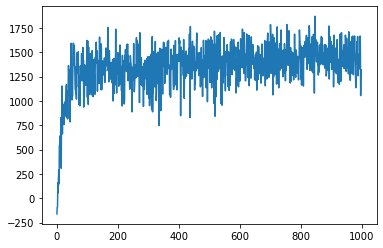

In [13]:
# Plot the convergence based on epsides and score and we can find 
# that it has risen initially and remaining constant after ward
plt.plot(episodes, scores)


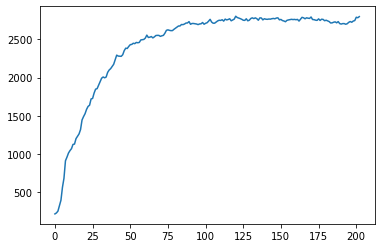

In [14]:
# Plot some of the values that are tracked. and we can see the action value have converged
values = States_track['3-0-0']['3-4']
plt.plot(values)

In [ ]:
    sample_q_values = [('3-0-0', '3-4'), ('2-0-0', '2-3'), ('1-0-0', '2-3'), ('4-0-0', '3-1'), ('4-0-0', '1-4'), ('4-0-0', '4-1'), 
                       ('4-0-0', '3-2'), ('4-0-0', '2-4'), ('4-0-0', '4-2')] 

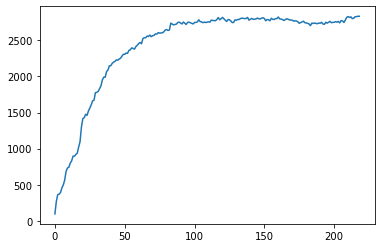

In [26]:
# Plot some of the values that are tracked. and we can see the action value have converged
values = States_track['4-0-0']['4-1']
plt.plot(values)

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [27]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

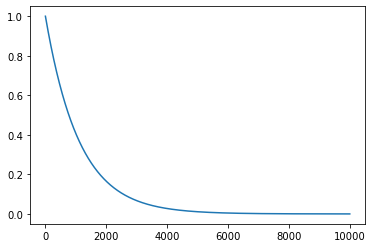

In [28]:
plt.plot(time, epsilon)
plt.show()